# This is the data engineering scripts for team 8
## Group Members: Pryor Vo, Xiangyuan Ren, Peng Chen, Ge Chang, Siqi Qin

In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
# Draw inline
%matplotlib inline
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale = 1.1)

In [2]:
warnings.filterwarnings('ignore')

sessions= pd.read_csv('input/sessions.csv')
train_users = pd.read_csv('input/train_users_2.csv')
test_users = pd.read_csv('input/test_users.csv')
age_gender_buckets=pd.read_csv('input/age_gender_bkts.csv')
countries=pd.read_csv('input/countries.csv')

# Basic Visualization and Pre-processing

In [3]:
train_users.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


## Visualization of Population in Destination Countries

In [4]:
buckets=['0-4','5-9','10-14','15-19','20-24','25-29','30-34','35-39','40-44','45-49','50-54','55-59','60-64',  \
         '65-69','70-74','75-79','80-84','85-89','90-94','95-99','100+']

In [5]:
gender=widgets.RadioButtons(
    options=['male', 'female'],
    description='Gender:',
    disabled=False
)
destination=widgets.RadioButtons(
    options=list(countries.country_destination),
    description='Country:',
    disabled=False
)
def country_info(gender, destination):
    '''
    This function performs the visualization of population in a certain country
    You can switch among different destination countries and genders
    *param gender: the gender of population you want to visualize
    *param destination: the destination country of population you want to visualize
    '''
    country_pop=age_gender_buckets.loc[(age_gender_buckets['country_destination'] == destination) & (age_gender_buckets['gender']==gender),('age_bucket','population_in_thousands')]
    pop=[float(country_pop.loc[country_pop['age_bucket']==i,'population_in_thousands']) for i in buckets]
    y_pos = range(0,101,5)
    y_val=pop
    if gender=='female':
        plt.bar(y_pos, y_val, align='edge', alpha=0.5,color='#F35FCD',width=4)
    elif gender=='male':
        plt.bar(y_pos, y_val, align='edge', alpha=0.5,color='#00AFFF',width=4)
    plt.xticks(range(0,101,5), rotation = 70)
    plt.xlabel('Ages')
    plt.ylabel('Population in Thousands')
    plt.show()
widgets.interact(country_info,gender=gender,destination=destination)

A Jupyter Widget

<function __main__.country_info>

## Visualization of Gender and Destination Related Stuffs

In [6]:
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)
users.gender.replace('-unknown-', np.nan, inplace=True)
users.age.describe()

count    250922.000000
mean         49.668335
std         155.666302
min           1.000000
25%          28.000000
50%          34.000000
75%          43.000000
max        2014.000000
Name: age, dtype: float64

Distribution of destination country regarding gender

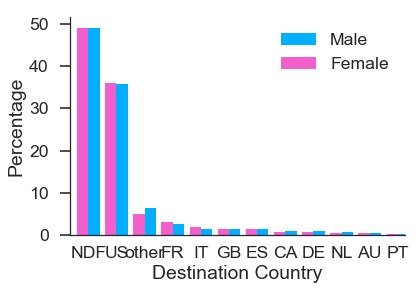

In [7]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

male_destinations.plot(kind='bar', width=0.4, color='#00AFFF', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=0.4, color='#F35FCD', position=1, label='Female', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

Distribution of ages within 15 to 96

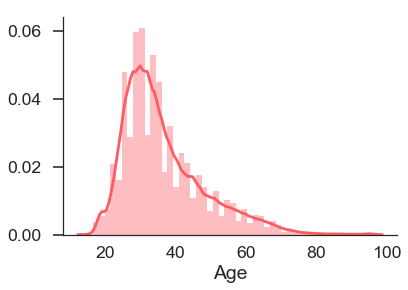

In [8]:
users.loc[users.age > 96, 'age'] = np.nan
users.loc[users.age < 15, 'age'] = np.nan
sns.distplot(users.age.dropna(), color='#FD5C64')

plt.xlabel('Age')
sns.despine()
plt.show()

## Country destination booking ratio of [destination] vs [All other countries excluding Not Defined]

In [9]:
x=widgets.RadioButtons(
    options=list(countries.country_destination)+['other'],
    value='US',
    description='Country info from...',
    disabled=False,
)
y=widgets.SelectionSlider(
    options=[2,4,5,10,16,20],
    value=5,
    description='Age jumps (end point uninclusive)',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)
def find_destination_ratio(destination,age_interval):
    '''
    This function shows the ratio of booking in given destination vs other countries (excluding NDF)
    *param destination: the target country destination that you want to analyse with 
    *param age_interval: the age step for the x axis (age)
    '''
    #Establish different dataframes to compare
    df=users.loc[users['country_destination'] == destination, 'age'];
    df_comparison=users.loc[users['country_destination'] != destination, 'age']
    df_comparison2=users.loc[users['country_destination'] == 'NDF', 'age']
    
    #Create age pools for better graph readability
    bins=range(15,96,age_interval)
    
    #Value count for each pool in each dataframe, reindexed to be in order
    count_interval=pd.cut(df,bins=bins,right=False).value_counts().reindex(pd.cut(df,bins=bins,right=False).cat.categories)
    count_comparison=pd.cut(df_comparison,bins=bins,right=False).value_counts().reindex(pd.cut(df_comparison,bins=bins,right=False).cat.categories)-pd.cut(df_comparison2,bins=bins,right=False).value_counts().reindex(pd.cut(df_comparison2,bins=bins,right=False).cat.categories)
    
    #Put into numpy array to plot
    users_booking_pools=np.array(count_interval,dtype=float)
    users_booking_comparison=np.array(count_comparison,dtype=float)
    users_booking_percent=users_booking_pools/users_booking_comparison*100
    
    #Plot
    y_pos = xrange(15,95,age_interval)
    y_val=users_booking_percent
    plt.bar(y_pos, y_val, align='edge', alpha=0.5,color='#FFA35D',width=100/(len(xrange(15,96,age_interval))+5))
    plt.xticks(xrange(15,96,age_interval), rotation = 90)
    plt.xlabel('Ages')
    plt.ylabel('Percent of Users Who Book for %s vs Other Countries' % x.options[x.index])
    plt.show()
widgets.interact(find_destination_ratio,destination=x,age_interval=y)

A Jupyter Widget

<function __main__.find_destination_ratio>

## Comparison of different country bookings with a set age threshold

In [10]:

age=widgets.SelectionSlider(
    options=range(18,91,2),
    value=50,
    description='Age threshold at.....',
    disabled=False,
    continuous_update=True,
    orientation='horizontal',
    readout=True
)

def find_destination_ratio_agethreshold(age):
    '''
    This function shows the booking ratio of younger and older groups splitting with the given age threshold
    *param age: the age threshold used to split younger and older.
    '''
    younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
    older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

    younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
    older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

    younger_destinations.plot(kind='bar', width=0.4, color='#00FFFF', position=0, label='Youngers', rot=0)
    older_destinations.plot(kind='bar', width=0.4, color='#FFA500', position=1, label='Olders', rot=0)

    plt.legend()
    plt.xlabel('Destination Country')
    plt.ylabel('Percentage')

    sns.despine()
    plt.show()
widgets.interact(find_destination_ratio_agethreshold,age=age)

A Jupyter Widget

<function __main__.find_destination_ratio_agethreshold>

In this part, we shall specifically focus on the three items: affiliate_channel affiliate_provider first_affiliate_tracked
The meaning of the three items are:
    1. affiliate_channel: what kind of paid marketing
    2. affiliate_provider: where the marketing is e.g. google, craigslist, other
    3. first_affiliate_tracked: whats the first marketing the user interacted with before the signing up

In [11]:
def showUnique(keyword):
    '''
    This function helps to show the potential unique choices 
    of a given keyword in the training dataset
    * param keyword : the keyword of the information you want
    '''
    assert isinstance(keyword, str)
    selected = train_users[keyword]
    selected_unique = selected.unique()
    print('Here are all the potential '+ keyword + ':')
    print(selected_unique)
    print('\n')

affiliate_keywords = ['country_destination', 'affiliate_channel', \
                  'affiliate_provider', 'first_affiliate_tracked']
_ = map(showUnique, affiliate_keywords)

Here are all the potential country_destination:
['NDF' 'US' 'other' 'FR' 'CA' 'GB' 'ES' 'IT' 'PT' 'NL' 'DE' 'AU']


Here are all the potential affiliate_channel:
['direct' 'seo' 'other' 'sem-non-brand' 'content' 'sem-brand' 'remarketing'
 'api']


Here are all the potential affiliate_provider:
['direct' 'google' 'other' 'craigslist' 'facebook' 'vast' 'bing' 'meetup'
 'facebook-open-graph' 'email-marketing' 'yahoo' 'padmapper' 'gsp' 'wayn'
 'naver' 'baidu' 'yandex' 'daum']


Here are all the potential first_affiliate_tracked:
['untracked' 'omg' nan 'linked' 'tracked-other' 'product' 'marketing'
 'local ops']




## Visulization of Affiliate Related Stuffs

In [12]:
utilize = train_users[['country_destination','affiliate_channel','affiliate_provider','first_affiliate_tracked']]
utilize.head()

,country_destination,affiliate_channel,affiliate_provider,first_affiliate_tracked
0,NDF,direct,direct,untracked
1,NDF,seo,google,untracked
2,US,direct,direct,untracked
3,other,direct,direct,untracked
4,US,direct,direct,untracked


In [13]:
def uniqueCount_percentage(keyword, limit = -1):
    '''
    This is the function to visualize distribution of all unique items in train_user[keyword]
    * param keyword : the keyword of the information you want
    * limit : top limit counted will be considered, default value -1 means all should be counted
    '''
    print('Result for ' + keyword + '\n')
    all_keys = train_users[keyword]
    all_counts = train_users[keyword].value_counts()
    book_counts = train_users[train_users['country_destination'] != 'NDF'][keyword].value_counts()
    if limit > 0:
        all_counts = all_counts[ : limit]
        book_counts = book_counts[ : limit]
    
    # deal with missing value in booking
    for d in all_counts.index:
        if d not in book_counts.index:
            book_counts[d] = 0

    per_counts = map(lambda x : book_counts[x] * 1.0 / all_counts[x], all_counts.index)
    org_all = map(lambda x : all_counts[x], all_counts.index)
    org_book = map(lambda x : book_counts[x], all_counts.index)
    org_ndf = map(lambda x,  y: x - y, org_all, org_book)
    org_dict = {'Book Customer': org_book, 'NDF Customer': org_ndf, 'Total Customer': org_all, 'Book Percent': per_counts}
    df = pd.DataFrame(org_dict, columns = ['Book Customer', 'NDF Customer', 'Total Customer', 'Book Percent'], index = all_counts.index)
    print(df)
    ax = df[['Book Customer', 'NDF Customer']].plot(kind="barh", stacked=True, figsize=(6, 8))

Result for affiliate_channel

               Book Customer  NDF Customer  Total Customer  Book Percent
direct                 59398         78329          137727      0.431273
sem-brand              11094         14951           26045      0.425955
sem-non-brand           7150         11694           18844      0.379431
other                   3600          5361            8961      0.401741
seo                     3955          4708            8663      0.456539
api                     2785          5382            8167      0.341006
content                  558          3390            3948      0.141337
remarketing              368           728            1096      0.335766


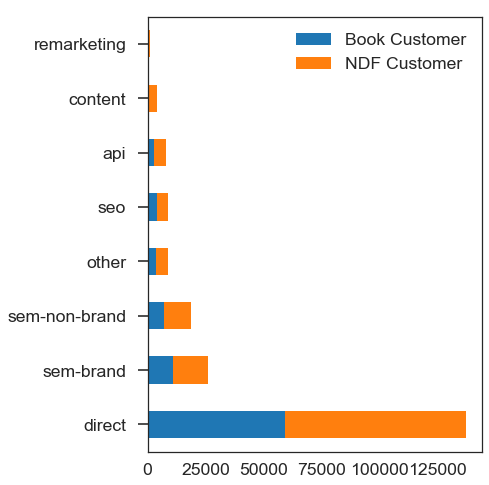

In [14]:
uniqueCount_percentage('affiliate_channel', -1)

In this part, we can see that among all the affiliate channels, direct, seo are tht most two popular paid marketing ways. Paid search marketing means you advertise within the sponsored listings of a search engine or a partner site by paying either each time your ad is clicked (pay-per-click - PPC) or less commonly, when your ad is displayed (cost-per-impression - CPM). Therefore we can see that most customer come into airbnb without using mach paid marketing method.

Result for affiliate_provider

                     Book Customer  NDF Customer  Total Customer  Book Percent
direct                       59234         78192          137426      0.431025
google                       20779         30914           51693      0.401969
other                         4663          7886           12549      0.371583
craigslist                    1616          1855            3471      0.465572
bing                           833          1495            2328      0.357818
facebook                       792          1481            2273      0.348438
vast                           271           558             829      0.326900
padmapper                      252           516             768      0.328125
facebook-open-graph            141           404             545      0.258716
yahoo                          174           322             496      0.350806
gsp                             37           416             453      0.081678
meetup               

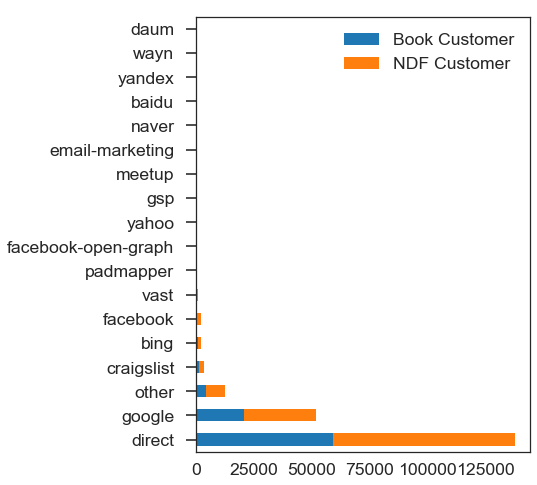

In [15]:
uniqueCount_percentage('affiliate_provider', -1)

From this plot we can see that most paid marketings lie in the Google except the diret paid marketing way. It means we may invest more paid marketing ways which is highly related to the Google. 

Result for first_affiliate_tracked

               Book Customer  NDF Customer  Total Customer  Book Percent
untracked              47739         61493          109232      0.437042
linked                 20102         26185           46287      0.434290
omg                    16425         27557           43982      0.373448
tracked-other           2290          3866            6156      0.371995
product                  542          1014            1556      0.348329
marketing                 63            76             139      0.453237
local ops                  9            25              34      0.264706


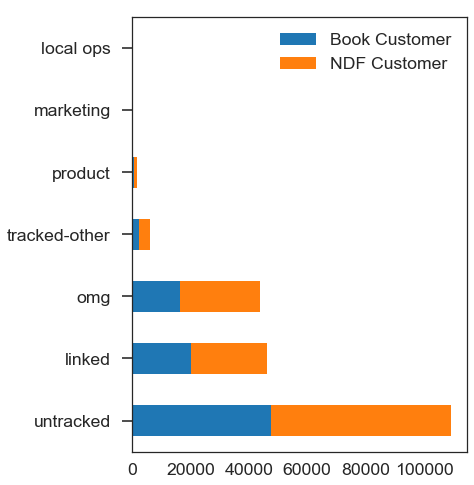

In [16]:
uniqueCount_percentage('first_affiliate_tracked', -1)

The first_affiliate_tracked means that before signing up, what is the first marketing the user is interacted with. It shows that the aside from the untracked information, the OMG group (a marketing company has the most affect with highest user interacting number). Another popular company the user is interacting is NAN group.

This shows that when the user are interacting with omg and nan, they have more potential to log into the airbnb.

# Data Analysis of Affiliate Related Stuffs

Based on the data visulization we obtained in the former chapter, we can put the two assumptions here:
   1. A large scale of customer sign up and make the booking directly without any optimization methods, this means that they have strong motivation and goal to start their trip using airbnb.
   2. Using Google with omg/nan might be the most common way user make booking aside from the direct way.
   
Next thing we want to do check the age composition in the differemt choices

## Age composition between Google and Direct

In [17]:
def box_hist(target, keyword):
    '''
    This function draws the box plot of data with given keyword equals the target one
    *param target: the target value which the data[keyword] should be equal to
    *param keyword: the keyword of data that you are interested in
    '''
    age_group  = train_users[['country_destination','affiliate_channel','affiliate_provider','first_affiliate_tracked','age']]
    age_group = age_group[age_group['age']>=60]
    age_group = age_group[age_group['age']<=80]
    df_3 = age_group[age_group[keyword]==target]
    df_3 = df_3['age']
    plt.figure()
    df_3.plot.hist(stacked=True, bins=20)
    plt.figure()
    df_3.plot.box()

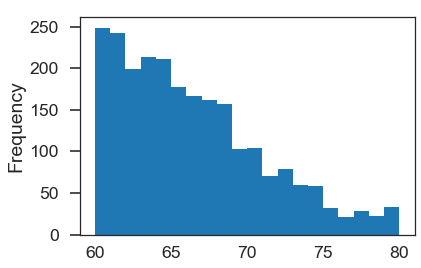

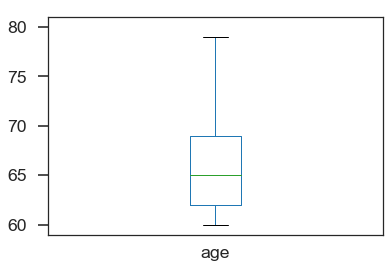

In [18]:
box_hist('google','affiliate_provider')

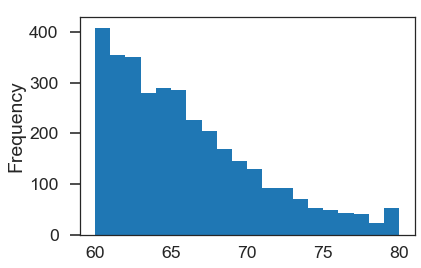

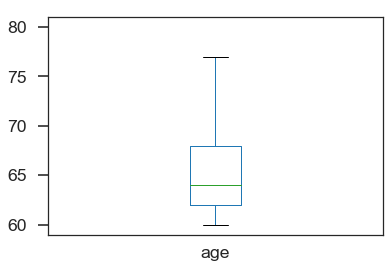

In [19]:
box_hist('direct','affiliate_provider')

We had a research on the old group people as the young age group has the similar distribution in both 'direct' and 'google'.
From the box plots and histogram plots we can see the user using google has a larger variance and more popular in the old group whose age is larger than 60. This means they may reach the google to get to know ther airbnb first.

## Age composition in omg group

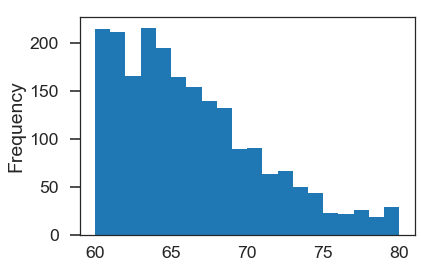

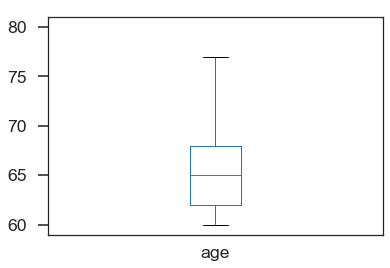

In [20]:
box_hist('omg','first_affiliate_tracked')

From this part, we can draw the conclusion that the variance of 'OMG' group is much larger than the average group. This means this group may have a wider customer range.

In  this part, we want to figure out how users interacted with "Sharing Economy" by looking into the distribution of assorted records;

In the figure of # Visulization of affiliate_Provider, we can see that the 'direct' method outnumbers other methods in a siginificant scale,
This indicates that most users reach the airbnb directly. This means that they mght have known and accepted the concepts of "sharing economy" and willing to give it a shot. To further boraden the market, we may want to spread the sharing economy first and then the user may want to accept the concept.


The next thing we focus on is the old age group between the 'google' and 'direct' way, from this picture we can see that though the number difference between the 'direct' and 'google' is relatively large, the difference in the old group is not obvious, this support our conslusion that the airbnb is not that popular in the old group (judged by whether they can reach airbnb by 'direct' way). The reason for this result may be that the sharing economy is not that popular in the old group. 

# Sessions Part

Extract user_id and destination for easier merge, shorten_users contains id and destination only

In [21]:
shorten_users = train_users[['id','country_destination']]
shorten_users.rename(columns={'id': 'user_id'}, inplace=True) 
shorten_users.head()

,user_id,country_destination
0,gxn3p5htnn,NDF
1,820tgsjxq7,NDF
2,4ft3gnwmtx,US
3,bjjt8pjhuk,other
4,87mebub9p4,US


Visualize the distribution of destination in the training set

In [22]:
print(shorten_users.groupby(['country_destination'])['user_id'].nunique().reset_index())

   country_destination  user_id
0                   AU      539
1                   CA     1428
2                   DE     1061
3                   ES     2249
4                   FR     5023
5                   GB     2324
6                   IT     2835
7                  NDF   124543
8                   NL      762
9                   PT      217
10                  US    62376
11               other    10094


Add labels to data, count = 1 means booking, count = 0 means NDF

In [23]:
shorten_users['count']=shorten_users['country_destination']
shorten_users.loc[shorten_users['count'] != 'NDF','count'] = 1
shorten_users.loc[shorten_users['count'] == 'NDF','count'] = 0

shorten_users.head()

,user_id,country_destination,count
0,gxn3p5htnn,NDF,0
1,820tgsjxq7,NDF,0
2,4ft3gnwmtx,US,1
3,bjjt8pjhuk,other,1
4,87mebub9p4,US,1


Merge the info in sessions and training data

In [24]:
sessions = pd.merge(shorten_users,sessions,on='user_id',how='inner')
sessions.head()

,user_id,country_destination,count,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,other,1,lookup,NaN,NaN,Windows Desktop,319.0
1,d1mm9tcy42,other,1,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,other,1,lookup,NaN,NaN,Windows Desktop,301.0
3,d1mm9tcy42,other,1,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,other,1,lookup,NaN,NaN,Windows Desktop,435.0


Visualize the variaty of each keywords in the merged data

In [25]:
sessions.apply(lambda x: x.nunique(),axis=0)

user_id                 73815
country_destination        12
count                       2
action                    331
action_type                 9
action_detail             128
device_type                14
secs_elapsed           256593
dtype: int64

## Time Interval Analysis (Time Interval is the time one user spends on Airbnb)

Count the total time of each user

In [26]:
grpby = sessions.groupby(['user_id'])['secs_elapsed'].sum().reset_index()
grpby.columns = ['user_id','secs_elapsed']
grpby = pd.merge(grpby,shorten_users,on='user_id',how='inner')
grpby.head()

,user_id,secs_elapsed,country_destination,count
0,00023iyk9l,867896.0,US,1
1,001wyh0pz8,282965.0,NDF,0
2,0028jgx1x1,297010.0,NDF,0
3,002qnbzfs5,6487080.0,US,1
4,0035hobuyj,5724670.0,US,1


In [27]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def timeIntervalVisual(groupNum, typeCurr):
    '''
    This is the visualization function for time interval distribution
    *param: groupNum is the number of groups you want to divided the time intervals into
    '''
    assert groupNum > 1
    types = ['All', 'Book', 'NDF']
    assert typeCurr in types
    grpby['timeclass'] = pd.qcut(grpby['secs_elapsed'], groupNum)
    time_raw = grpby
    if typeCurr == types[1]:
        time_raw = grpby[grpby['count'] == 1]
    elif typeCurr == types[2]:
        time_raw = grpby[grpby['count'] == 0]
    times = time_raw[['timeclass', 'count']].groupby(['timeclass']).count().reset_index()
    times.index = times['timeclass']
    times.plot('timeclass', 'count', kind='pie', autopct='%1.1f%%', title = 'Time Interval(secs) Distribution', figsize = (10, 10))
    plt.legend(loc='center left', bbox_to_anchor=(1.3, 0.5))
    plt.axis('off')
    plt.show()
    
interact(timeIntervalVisual, groupNum = widgets.IntSlider(min = 2, max = 10, step = 1, value = 5), \
        typeCurr = widgets.Dropdown(options = {'All', 'Book', 'NDF'}))

A Jupyter Widget

<function __main__.timeIntervalVisual>

Conclusion: We can see that the Booked users spent more time on the Airbnb

# Action Type Analysis (Action Type is the action one user is recorded in his activity log)

Firstly, see the distribution of user action type on action level

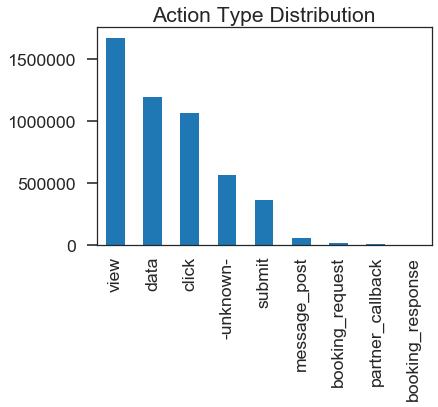

In [28]:
sessions.action_type.value_counts().plot(kind= 'bar', title = 'Action Type Distribution')

Remove the unknown one

In [29]:
infos = []
for key in sessions.action_type.unique()[1:]:
    if key != np.nan and key != '-unknown-':
        total = len(sessions[sessions.action_type == key])
        if total != 0:
            book = sessions[sessions.action_type == key]['count'].sum()
            percent = 1.0 * book / total * 100
            infos.append([key, book, total, percent])

Percentage of each action_type regarding booking class and total numbers, action level statistics

In [30]:
action_Summary = pd.DataFrame(np.array(infos), columns= ['action_type', 'book #', 'total #', 'booking percent'])
action_Summary.sort_values('booking percent', ascending = 0)

,action_type,book #,total #,booking percent
5,booking_request,9081,10695,84.9088359046
4,message_post,32299,55567,58.1262259974
6,partner_callback,3798,7005,54.2184154176
7,booking_response,1,2,50.0
0,click,481757,1064436,45.2593674021
2,view,748404,1669723,44.8220453333
1,data,516182,1188495,43.4315668135
3,submit,138407,357371,38.7292197744


distribution of each action type on user level

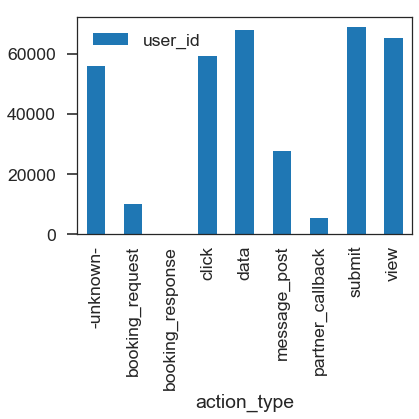

In [31]:
sessions.groupby(['action_type'])['user_id'].nunique().reset_index().plot('action_type', 'user_id', kind = 'bar')

In [32]:
action_type = pd.pivot_table(sessions, index = ['user_id'],columns = ['action_type'],
                             values = 'action',aggfunc=len,fill_value=0).reset_index()
action_type= pd.merge(action_type,shorten_users,on='user_id',how='inner')
action_type.head()

,user_id,-unknown-,booking_request,booking_response,click,data,message_post,partner_callback,submit,view,country_destination,count
0,00023iyk9l,0,1,0,4,9,1,1,0,21,US,1
1,001wyh0pz8,6,0,0,66,2,0,0,3,8,NDF,0
2,0028jgx1x1,1,0,0,9,5,0,0,1,15,NDF,0
3,002qnbzfs5,184,1,0,140,140,16,0,15,216,US,1
4,0035hobuyj,9,0,0,206,41,3,0,4,55,US,1


In [33]:
def actionTypeVisual(typeCurr):
    '''
    This function performs the visualization of the action type distribution
    *param typeCurr: the group of data you want to show visualization with
            "All" means all the data, "Book" means only the booked users and "NDF" means the not booked ones
    '''
    types = ['All', 'Book', 'NDF']
    assert typeCurr in types
    type_info = [['all', 0]]
    action_raw = action_type
    if typeCurr == types[1]:
        action_raw = action_type[action_type['count'] == 1]
    elif typeCurr == types[2]:
        action_raw = action_type[action_type['count'] == 0]
    for k in action_raw.columns[2:-2]:
        count = action_raw[k].sum()
        type_info.append([k, count])
        type_info[0][1] += int(count)
    type_info = pd.DataFrame(type_info, columns=['action_type', 'count'])
    type_info.plot('action_type', 'count', kind='bar', title = typeCurr, color='#FD5C64', rot=90)
interact(actionTypeVisual, typeCurr = widgets.Dropdown(options = {'All', 'Book', 'NDF'}))

A Jupyter Widget

<function __main__.actionTypeVisual>

# Device Type Analysis (Device Type is the device that one user used to perform his action)

In [34]:
sessions.groupby(['device_type'])['user_id'].nunique().reset_index()

,device_type,user_id
0,-unknown-,13126
1,Android App Unknown Phone/Tablet,2757
2,Android Phone,3474
3,Blackberry,59
4,Chromebook,260
5,Linux Desktop,354
6,Mac Desktop,28893
7,Opera Phone,1
8,Tablet,848
9,Windows Desktop,24768


people may have more than one devices

In [35]:
sessions.groupby(['user_id'])['device_type'].nunique().reset_index().head() 

,user_id,device_type
0,00023iyk9l,2
1,001wyh0pz8,1
2,0028jgx1x1,2
3,002qnbzfs5,2
4,0035hobuyj,1


Device

In [36]:
device_type = pd.pivot_table(sessions, index = ['user_id'],columns = ['device_type'],values = 'action',
                             aggfunc=len,fill_value=0).reset_index()
device_type= pd.merge(device_type,shorten_users,on='user_id',how='inner')
device_type.head()

,user_id,-unknown-,Android App Unknown Phone/Tablet,Android Phone,Blackberry,Chromebook,Linux Desktop,Mac Desktop,Opera Phone,Tablet,Windows Desktop,Windows Phone,iPad Tablet,iPhone,iPodtouch,country_destination,count
0,00023iyk9l,0,0,0,0,0,0,36,0,0,0,0,0,4,0,US,1
1,001wyh0pz8,0,90,0,0,0,0,0,0,0,0,0,0,0,0,NDF,0
2,0028jgx1x1,30,0,1,0,0,0,0,0,0,0,0,0,0,0,NDF,0
3,002qnbzfs5,14,0,0,0,0,0,0,0,0,0,0,0,775,0,US,1
4,0035hobuyj,0,0,0,0,0,0,489,0,0,0,0,0,0,0,US,1


In [37]:
def deviceTypeVisual(typeCurr):
    '''
    This function performs the visualization of the device type distribution
    *param typeCurr: the group of data you want to show visualization with
            "All" means all the data, "Book" means only the booked users and "NDF" means the not booked ones
    '''
    types = ['All', 'Book', 'NDF']
    assert typeCurr in types
    type_info = [['all', 0]]
    device_raw = device_type
    if typeCurr == types[1]:
        device_raw = device_type[device_type['count'] == 1]
    elif typeCurr == types[2]:
        device_raw = device_type[device_type['count'] == 0]
    for k in device_raw.columns[2:-2]:
        count = device_raw[k].sum()
        type_info.append([k, count])
        type_info[0][1] += int(count)
    type_info = pd.DataFrame(type_info, columns=['device_type', 'count'])
    type_info.plot('device_type', 'count', kind='bar', title = typeCurr, color='#FD5C64', rot=90)
interact(deviceTypeVisual, typeCurr = widgets.Dropdown(options = {'All', 'Book', 'NDF'}))

A Jupyter Widget

<function __main__.deviceTypeVisual>

## Combine action type and time 

In [38]:
def actionTypeTime(typeCurr):
    '''
    This function performs the visualization of the total time elapsed within each device type
    *param typeCurr: the group of data you want to show visualization with
            "All" means all the data, "Book" means only the booked users and "NDF" means the not booked ones
    '''
    types = ['All', 'Book', 'NDF']
    assert typeCurr in types
    action_time = sessions
    if typeCurr == types[1]:
        action_time = sessions[sessions['count'] == 1]
    elif typeCurr == types[2]:
        action_time = sessions[sessions['count'] == 0]
    
    action_time.groupby(['action_type']
                     )['secs_elapsed'].sum().reset_index().plot('action_type', 'secs_elapsed',kind = 'bar',rot = 90)
interact(actionTypeTime, typeCurr = widgets.Dropdown(options = {'All', 'Book', 'NDF'}))

A Jupyter Widget

<function __main__.actionTypeTime>

## combine everything

In [39]:
sessions_data = pd.merge(action_type,device_type,on='user_id',how='inner')
sessions_data = pd.merge(sessions_data,grpby,on='user_id',how='inner')
sessions_data.head().T

,0,1,2,3,4
user_id,00023iyk9l,001wyh0pz8,0028jgx1x1,002qnbzfs5,0035hobuyj
-unknown-_x,0,6,1,184,9
booking_request,1,0,0,1,0
booking_response,0,0,0,0,0
click,4,66,9,140,206
data,9,2,5,140,41
message_post,1,0,0,16,3
partner_callback,1,0,0,0,0
submit,0,3,1,15,4
view,21,8,15,216,55


NDF with less time spent

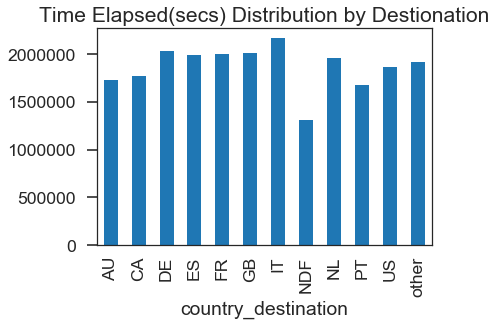

In [40]:
sessions_data.groupby(['country_destination']  \
                     )['secs_elapsed'].mean().reset_index().plot('country_destination', \
                                        'secs_elapsed',kind = 'bar', rot = 90, legend = False, \
                                         title = "Time Elapsed(secs) Distribution by Destionation")

if partner_callback exist, the destination is highly likely to be an English spoken country as most of the users are from US, it is easier to communicate with call (US, CA, GB)

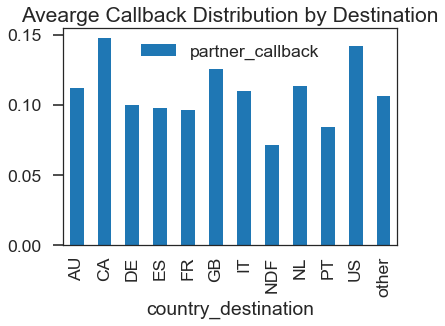

In [41]:
sessions_data.groupby(['country_destination']
                     )['partner_callback'].mean().reset_index().plot('country_destination', \
                    'partner_callback',kind = 'bar', title = 'Avearge Callback Distribution by Destination' ,rot = 90)

NDF with less message post

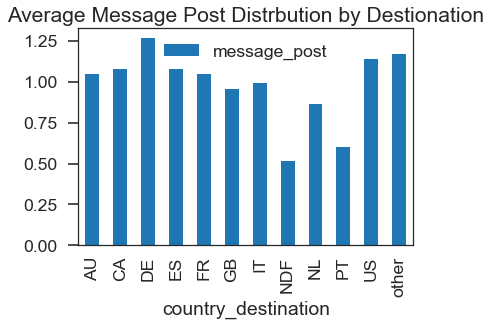

In [42]:
sessions_data.groupby(['country_destination']
                     )['message_post'].mean().reset_index().plot('country_destination', \
                    'message_post',kind = 'bar',title = 'Average Message Post Distrbution by Destionation' ,rot = 90)

In [43]:
from matplotlib.colors import Colormap
bar_order_origin = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
cat_vars = ['partner_callback', 'message_post', 'data', 'view','booking_request','booking_response','submit', 'click']

def actionTypeCounterVisual(NDF, US, other, FR, IT, GB, ES, CA, DE, NL, AU, PT):
    '''
    This function shows the distribution of the destionation countries regarding to 
                                        the action frequency of each action type.
    *param NDF, US, other, FR, IT, GB, ES, CA, DE, NL, AU, PT decides whether this country 
                                        will be taken into consideration
    '''
    selections = [NDF, US, other, FR, IT, GB, ES, CA, DE, NL, AU, PT]
    fig, ax5 = plt.subplots(nrows=4, ncols=2, figsize=(16, 16))
    raw_Data = sessions_data
    bar_order = ['NDF','US','other','FR','IT','GB','ES','CA','DE','NL','AU','PT']
    for i in range(len(selections)):
        if selections[i] == False:
            raw_Data = raw_Data[raw_Data.country_destination != bar_order[i]]
            bar_order[i] = None
    
    bar_order = list(filter(None, bar_order))
    for i,var in enumerate(cat_vars):
        pltCatVar(raw_Data, bar_order, var, ax5,i)
    plt.tight_layout()
    #ax5[0].set_position([box.x0, box.y0 + box.height * 0.4, box.width, box.height * 0.6])
    ax5[3][1].legend(loc='upper center', bbox_to_anchor=(-0.15, -0.7), ncol=6)

def pltCatVar(input_Data, bar_order, var,axis,ax_num):
    '''
    This is the plot function of country distribution regarding to the frequency of the given keywords
    *param input_Data: the raw data to process with
    *param bar_order: the order of the destination countries
    *param var: the keyword of action type that we are interested in
    *param axis, ax_num: parameters related to subplot
    '''
    ctab = pd.crosstab([input_Data[var]], input_Data.country_destination).apply(lambda x: x/x.sum(), axis=1)
    temp = [ctab.index[0]] * (ctab.index.size / 5)
    temp.extend([ctab.index[ctab.index.size * 1 / 5]] * (ctab.index.size * 2 / 5 - ctab.index.size / 5))
    temp.extend([ctab.index[ctab.index.size * 2 / 5]] * (ctab.index.size * 3 / 5 - ctab.index.size * 2 / 5))
    temp.extend([ctab.index[ctab.index.size * 3 / 5]] * (ctab.index.size * 4 / 5 - ctab.index.size *3 / 5))
    temp.extend([ctab.index[ctab.index.size * 4 / 5]] * (ctab.index.size - ctab.index.size * 4 / 5))
    ctab.index = temp
    ctab = ctab.groupby(ctab.index).mean()
    ax = ctab[bar_order].plot(kind='bar', stacked=True, ax=axis.reshape(-1)[ax_num],legend=False, 
                         colormap='terrain', title = var)
    axis = []
    for i in range(4):
        axis.append(str(ctab.index[ctab.index.size * i / 5]) + " to " + str(ctab.index[ctab.index.size * (i + 1) / 5]))
    axis.append("greater " + str(ctab.index[ctab.index.size * 4 / 5]))
    ax.set_xticklabels(axis, rotation=45)
    if var == 'booking_response':
        ax.set_xticklabels([0, 1])
        

interact(actionTypeCounterVisual, NDF = True, US = True, other = True, FR = True, IT = True, \
         GB = True, ES = True, CA = True, DE = True, NL = True, AU = True, PT = True)

A Jupyter Widget

<function __main__.actionTypeCounterVisual>

The more times of book_request, the more likely to be others

If not NDF, large data counts may be FR ,FR and IT has more message_post